#   LangGraph 활용 - 메시지 그래프 + 리듀서 구현 + 병렬 실행

---

## 환경 설정 및 준비

`(1) Env 환경변수`

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

`(2) 기본 라이브러리`

In [2]:
import os
from glob import glob

from pprint import pprint
import json

`(3) Langsmith tracing 설정`

In [3]:
# Langsmith tracing 여부를 확인 (true: langsmith 추척 활성화, false: langsmith 추척 비활성화)
import os
print(os.getenv('LANGSMITH_TRACING'))

true


---

## **Reducer (리듀서)**

- **State Reducer**는 LangGraph의 **상태 관리 핵심 메커니즘**

- 각 노드의 출력을 **전체 그래프 상태에 통합**하는 방식을 정의

- **Reducer의 필요성**:

    - **상태 덮어쓰기 문제**: 기본적으로 각 노드의 반환값은 해당 상태 키의 이전 값을 덮어쓰는 방식으로 동작 (override)
    
    - **누적 업데이트 필요**: 특히 메시지 리스트와 같은 경우, 이전 상태에 새로운 값을 추가하고 싶을 때가 있음 

`(1) Reducer를 별도로 지정하지 않은 경우 `

- **기본 Reducer**는 이전 값을 **자동으로 덮어쓰는** 방식으로 작동
- Reducer 설정이 없는 경우 **자동으로 기본값**이 적용
- 이는 단순한 상태 업데이트에는 적합하나 **데이터 누적이 필요한 경우 부적절**
- 기본 Reducer는 **간단한 상태 관리**에 적합하지만 복잡한 데이터 처리에는 한계가 있음

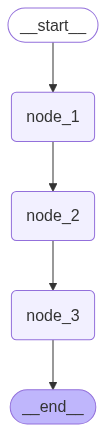

In [4]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 상태 정의 
class DocumentState(TypedDict):
    query: str
    documents: List[str]

# Node 1: query 업데이트
def node_1(state: DocumentState) -> DocumentState:
    print("---Node 1 (query update)---")
    query = state["query"]
    return {"query": query}

# Node 2: 검색된 문서 추가 
def node_2(state: DocumentState) -> DocumentState:
    print("---Node 2 (add documents)---")
    return {"documents": ["doc1.pdf", "doc2.pdf", "doc3.pdf"]}

# Node 3: 추가적인 문서 검색 결과 추가
def node_3(state: DocumentState) -> DocumentState:
    print("---Node 3 (add more documents)---")
    return {"documents": ["doc2.pdf", "doc4.pdf", "doc5.pdf"]}


# 그래프 빌드
builder = StateGraph(DocumentState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 논리 구성
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

# 그래프 실행
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))


In [5]:
# 초기 상태
initial_state = {"query": "채식주의자를 위한 비건 음식을 추천해주세요."}

# 그래프 실행 
final_state = graph.invoke(initial_state)

# 최종 상태 출력
print("-"*100)
print("최종 상태:")
print("쿼리:", final_state['query'])
print("검색된 문서:", final_state['documents'])

---Node 1 (query update)---
---Node 2 (add documents)---
---Node 3 (add more documents)---
----------------------------------------------------------------------------------------------------
최종 상태:
쿼리: 채식주의자를 위한 비건 음식을 추천해주세요.
검색된 문서: ['doc2.pdf', 'doc4.pdf', 'doc5.pdf']


`(2) Reducer를 별도로 지정하는 경우 `

- **Annotated**를 통해 **사용자 정의 Reducer**를 지정할 수 있음 
- **operator.add**를 사용하면 리스트 형태의 데이터를 **누적 관리**할 수 있음 
- 여기서는 기존 리스트에 새로운 메시지를 추가하는 방식으로 작동

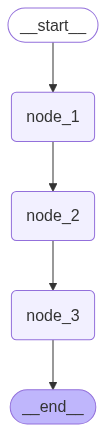

In [6]:
from operator import add
from typing import Annotated, TypedDict

class ReducerState(TypedDict):
    query: str
    documents: Annotated[List[str], add]

# Node 1: query 업데이트
def node_1(state: ReducerState) -> ReducerState:
    print("---Node 1 (query update)---")
    query = state["query"]
    return {"query": query}

# Node 2: 검색된 문서 추가 
def node_2(state: ReducerState) -> ReducerState:
    print("---Node 2 (add documents)---")
    return {"documents": ["doc1.pdf", "doc2.pdf", "doc3.pdf"]}

# Node 3: 추가적인 문서 검색 결과 추가
def node_3(state: ReducerState) -> ReducerState:
    print("---Node 3 (add more documents)---")
    return {"documents": ["doc2.pdf", "doc4.pdf", "doc5.pdf"]}

# 그래프 빌드
builder = StateGraph(ReducerState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 논리 구성
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

# 그래프 실행
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
# 초기 상태
initial_state = {"query": "채식주의자를 위한 비건 음식을 추천해주세요."}

# 그래프 실행 
final_state = graph.invoke(initial_state)

# 최종 상태 출력
print("-"*100)
print("최종 상태:")
print("쿼리:", final_state['query'])
print("검색된 문서:", final_state['documents'])

---Node 1 (query update)---
---Node 2 (add documents)---
---Node 3 (add more documents)---
----------------------------------------------------------------------------------------------------
최종 상태:
쿼리: 채식주의자를 위한 비건 음식을 추천해주세요.
검색된 문서: ['doc1.pdf', 'doc2.pdf', 'doc3.pdf', 'doc2.pdf', 'doc4.pdf', 'doc5.pdf']


`(3) Custom Reducer 사용 `

- **Custom Reducer**는 **복잡한 상태 관리**가 필요할 때 사용됨 
- **중복 제거**나 **최대/최소값 유지**와 같은 특수한 로직을 구현할 수 있음 
- 비즈니스 요구사항에 맞는 **맞춤형 상태 관리**가 가능
- 상황에 따라 **조건부 병합**과 같은 고급 기능을 구현할 수 있음 

In [11]:
from typing import TypedDict, List, Annotated

# Custom reducer: 중복된 문서를 제거하며 리스트 병합
def reduce_unique_documents(left: list | None, right: list | None) -> list:
    """Combine two lists of documents, removing duplicates."""
    if not left:
        left = []
    if not right:
        right = []
    # 중복 제거: set을 사용하여 중복된 문서를 제거하고 다시 list로 변환
    return sorted(list(set(left + right)))

# 상태 정의 (documents 필드 포함)
class CustomReducerState(TypedDict):
    query: str
    documents: Annotated[List[str], reduce_unique_documents]  # Custom Reducer 적용

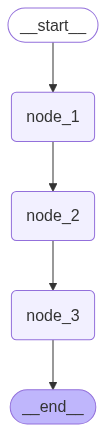

In [12]:
# Node 1: query 업데이트
def node_1(state: CustomReducerState) -> CustomReducerState:
    print("---Node 1 (query update)---")
    query = state["query"]
    return {"query": query}

# Node 2: 검색된 문서 추가 
def node_2(state: CustomReducerState) -> CustomReducerState:
    print("---Node 2 (add documents)---")
    return {"documents": ["doc1.pdf", "doc2.pdf", "doc3.pdf"]}

# Node 3: 추가적인 문서 검색 결과 추가
def node_3(state: CustomReducerState) -> CustomReducerState:
    print("---Node 3 (add more documents)---")
    return {"documents": ["doc2.pdf", "doc4.pdf", "doc5.pdf"]}

# 그래프 빌드
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 논리 구성
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

# 그래프 실행
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
# 초기 상태
initial_state = {"query": "채식주의자를 위한 비건 음식을 추천해주세요."}

# 그래프 실행 
final_state = graph.invoke(initial_state)

# 최종 상태 출력
print("-"*100)
print("최종 상태:")
print("쿼리:", final_state['query'])
print("검색된 문서:", final_state['documents'])

---Node 1 (query update)---
---Node 2 (add documents)---
---Node 3 (add more documents)---
----------------------------------------------------------------------------------------------------
최종 상태:
쿼리: 채식주의자를 위한 비건 음식을 추천해주세요.
검색된 문서: ['doc1.pdf', 'doc2.pdf', 'doc3.pdf', 'doc4.pdf', 'doc5.pdf']


---

## **Message 사용**

- **LangGraph**는 **메시지 목록** 기반의 채팅 모델 인터페이스를 활용

- `HumanMessage`와 `AIMessage` 등 다양한 메시지 타입을 지원

- 그래프 상태에서 대화 기록은 **메시지 객체 리스트**로 저장되며, 이를 통해 효율적인 대화 관리를 가능

- **reducer 함수**를 통해 상태 업데이트 시 메시지 목록이 어떻게 갱신될지 정의할 수 있음 

`(1) operator.add`

- 메시지 목록에 새로운 메시지를 간단히 추가하는 기본적인 reducer 함수
    1. `messages` 키가 메시지 리스트를 저장
    2. `add` reducer가 새 메시지를 기존 리스트에 추가
    3. 모든 종류의 메시지(`HumanMessage`, `AIMessage` 등)가 허용됨

- 주의사항:
    - `operator.add`는 단순히 리스트를 연결
    - 중복 메시지도 추가됨
    - 메시지 삭제나 수정은 불가능

In [14]:
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from operator import add

# 상태 정의
class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], add]

# LLM 인스턴스 생성
llm = ChatOpenAI(model="gpt-4.1-mini")


# chatbot 노드 함수 정의
def chatbot(state: GraphState) -> GraphState:
    # LLM을 사용하여 챗봇 메시지 생성
    return {"messages": [llm.invoke(state["messages"])]}

In [15]:
# Workflow Graph
builder = StateGraph(GraphState)

builder.add_node("chatbot", chatbot)

builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

# 그래프 컴파일
graph = builder.compile()

# 초기 상태
initial_state = {"messages": [("user", "안녕하세요!")]}

# 그래프 실행
for event in graph.stream(initial_state, stream_mode="values"):
    pprint(event['messages'])
    print("-"*100)

[('user', '안녕하세요!')]
----------------------------------------------------------------------------------------------------
[('user', '안녕하세요!'),
 AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 10, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': None, 'id': 'chatcmpl-BwMM5dcpsB1WbBfF8fQBZatnd7YQd', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--2d7692fb-1ba5-404f-82f3-24e336c2d629-0', usage_metadata={'input_tokens': 10, 'output_tokens': 10, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]
-----------------------------------------------

`(2) add_messages`

- 메시지 ID를 기반으로 기존 메시지를 업데이트하거나 새 메시지를 추가하는 고급 관리 기능을 제공
    - 새 메시지는 기존 목록에 추가
    - 기존 메시지 업데이트도 올바르게 처리 (메시지 ID를 추적)

- 기존 메시지의 중복 추가를 방지

In [16]:
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# add_messages 사용 상태 정의
class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# LLM 인스턴스 생성
llm = ChatOpenAI(model="gpt-4.1-mini")

# chatbot 노드 함수 정의
def chatbot(state: GraphState) -> GraphState:
    # LLM을 사용하여 챗봇 메시지 생성
    return {"messages": [llm.invoke(state["messages"])]}

# Workflow Graph
builder = StateGraph(GraphState)

builder.add_node("chatbot", chatbot)

builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

# 그래프 컴파일
graph = builder.compile()

# 초기 상태
initial_state = {"messages": [("user", "안녕하세요!")]}

# 그래프 실행
for event in graph.stream(initial_state, stream_mode="values"):
    pprint(event['messages'])
    print("-"*100)

[HumanMessage(content='안녕하세요!', additional_kwargs={}, response_metadata={}, id='f873a5a7-8885-4b6e-9e73-93ecef5c7993')]
----------------------------------------------------------------------------------------------------
[HumanMessage(content='안녕하세요!', additional_kwargs={}, response_metadata={}, id='f873a5a7-8885-4b6e-9e73-93ecef5c7993'),
 AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 10, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': None, 'id': 'chatcmpl-BwMMYbNYVoPGFQksXBccu9pGJSA2l', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--1e08d774-ae10-4aed-baa6-10481a8f2816-0', usage_metadata={'input_tokens': 10, 

`(3) MessagesState`

- **`MessagesState`** 는 메시지 관리를 위해 미리 정의된 상태 타입

- 이 상태는 **`add_messages` reducer**를 기본으로 사용하여 메시지 업데이트를 자동으로 처리

- `AnyMessage` 객체 리스트를 포함하는 **단일 `messages` 키**로 구성되어 있어 구조가 단순함 

In [17]:
from langgraph.graph import MessagesState

# messages 키를 가진 상태 생성 (messages 키는 기본 제공)
class GraphState(MessagesState):  # MessagesState 상속
    ... 
    # 추가적인 필드 정의 가능
    # custom_field: str

# LLM 인스턴스 생성
llm = ChatOpenAI(model="gpt-4.1-mini")

# chatbot 노드 함수 정의
def chatbot(state: GraphState) -> GraphState:
    # LLM을 사용하여 챗봇 메시지 생성
    return {"messages": [llm.invoke(state["messages"])]}

# Workflow Graph
builder = StateGraph(GraphState)

builder.add_node("chatbot", chatbot)

builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

# 그래프 컴파일
graph = builder.compile()

# 초기 상태
initial_state = {"messages": [("user", "안녕하세요!")]}

# 그래프 실행
for event in graph.stream(initial_state, stream_mode="values"):
    pprint(event['messages'])
    print("-"*100)

[HumanMessage(content='안녕하세요!', additional_kwargs={}, response_metadata={}, id='244af1ce-552b-4d0a-ad06-43c421c6787b')]
----------------------------------------------------------------------------------------------------
[HumanMessage(content='안녕하세요!', additional_kwargs={}, response_metadata={}, id='244af1ce-552b-4d0a-ad06-43c421c6787b'),
 AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 10, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': None, 'id': 'chatcmpl-BwMN3O9uvYWZAVg7d0JFipaKQI1NB', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--637c3b12-a0b8-4dd9-8f71-85081cce2e43-0', usage_metadata={'input_tokens': 10, 

`(4) MessagesState 커스텀 필드 추가`

- **MessagesState**를 상속받아 추가 필드를 포함하는 새로운 상태 타입을 정의할 수 있음 

- 기존 `messages` 키의 **`add_messages` reducer** 기능을 그대로 유지

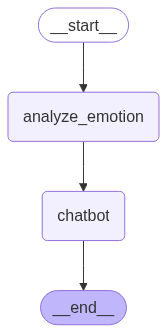

In [18]:
from typing import Optional
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_openai import ChatOpenAI

# MessagesState를 상속하여 커스텀 필드 추가
class GraphState(MessagesState):
    # 사용자의 감정 상태를 추적하는 필드 추가
    emotion: Optional[str] 

# LLM 인스턴스 생성
llm = ChatOpenAI(model="gpt-4.1-mini")

# 감정 분석을 위한 프롬프트 템플릿
EMOTION_PROMPT = """
사용자의 메시지를 분석하여 감정 상태를 파악해주세요.
가능한 감정 상태: 행복, 슬픔, 화남, 중립

사용자 메시지: {message}

감정 상태만 한 단어로 답변해주세요.
"""

# 감정 분석 노드
def analyze_emotion(state: GraphState) -> GraphState:
    # 가장 최근 사용자 메시지 가져오기
    last_message = state["messages"][-1].content
    
    # 감정 분석 실행
    emotion_analysis = llm.invoke(EMOTION_PROMPT.format(message=last_message))
    
    # 상태 업데이트
    return {
        "emotion": emotion_analysis.content.strip()
    }

# 챗봇 응답 노드
def chatbot(state: GraphState) -> GraphState:
    # 현재 감정 상태를 고려한 시스템 메시지 생성
    system_message = f"""
    사용자의 현재 감정 상태는 {state['emotion']}입니다.
    이를 고려하여 공감적이고 적절한 응답을 해주세요.
    """
    
    # 기존 메시지에 시스템 메시지 추가
    messages = [{"role": "system", "content": system_message}] + state["messages"]
    
    # LLM 응답 생성
    response = llm.invoke(messages)
    
    return {"messages": [response]}

# Workflow Graph 구성
builder = StateGraph(GraphState)

# 노드 추가
builder.add_node("analyze_emotion", analyze_emotion)
builder.add_node("chatbot", chatbot)

# 엣지 추가
builder.add_edge(START, "analyze_emotion")
builder.add_edge("analyze_emotion", "chatbot")
builder.add_edge("chatbot", END)

# 그래프 컴파일
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
# 초기 상태
initial_state = {
    "messages": [{"role": "user", "content": "오늘 정말 힘든 하루였어요..."}]
}

# 그래프 실행
for event in graph.stream(initial_state, stream_mode="values"):
    if "emotion" in event:
        print(f"감정 상태: {event['emotion']}")
    if "messages" in event:
        print("메시지:")
        for msg in event["messages"]:
            print(f"{msg.type}: {msg.content}")
    print("-"*100)

메시지:
human: 오늘 정말 힘든 하루였어요...
----------------------------------------------------------------------------------------------------
감정 상태: 슬픔
메시지:
human: 오늘 정말 힘든 하루였어요...
----------------------------------------------------------------------------------------------------
감정 상태: 슬픔
메시지:
human: 오늘 정말 힘든 하루였어요...
ai: 정말 많이 힘드셨나 봐요. 그런 날에는 마음도 몸도 지치기 마련이죠. 혹시 어떤 일 때문에 그렇게 힘들었는지 이야기해주실 수 있나요? 함께 이야기 나누며 조금이라도 위로가 되었으면 해요.
----------------------------------------------------------------------------------------------------


# ~ 14:44분까지 실습

---

## **병렬 처리**

- **분기(branching)** 기능을 통해 LangGraph에서 노드의 병렬 실행이 가능

- 병렬 처리는 **독립적인 작업**들을 동시에 실행함으로써 전체 처리 시간을 단축

- 다양한 데이터 소스에서 **정보 수집 및 처리**가 필요한 경우 병렬 실행이 특히 효과적

`(1) 표준 엣지를 사용한 분기 (Fan-out/Fan-in)`

- **Fan-out** 구조는 하나의 노드에서 여러 병렬 노드로 데이터를 분산시키는 방식을 구현

- **Fan-in** 구조는 병렬로 처리된 여러 노드의 결과를 단일 노드에서 취합하는 역할

- 가장 기본적이고 직관적인 병렬 처리 구조

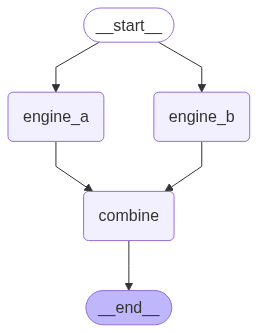

In [22]:
# 여러 검색 엔진에서 정보 가져오기

import operator
from typing import Annotated, Any, TypedDict
from langgraph.graph import StateGraph, START, END

# 상태 정의: 검색 결과를 누적할 리스트를 포함
class SearchState(TypedDict):
    search_results: Annotated[list, operator.add]

# 각 검색 엔진에 대한 노드 정의
def search_engine_a(state: SearchState):
    print("Searching with Engine A...")
    return {"search_results": ["Result A1", "Result A2"]}

def search_engine_b(state: SearchState):
    print("Searching with Engine B...")
    return {"search_results": ["Result B1"]}

def combine_results(state: SearchState):
    print("Combining search results...")
    return {"search_results": ["Combined Result"]}

# 그래프 구성
search_builder = StateGraph(SearchState)
search_builder.add_node("engine_a", search_engine_a)
search_builder.add_node("engine_b", search_engine_b)
search_builder.add_node("combine", combine_results)

# 엣지 연결: START -> engine_a, engine_b (병렬 실행) -> combine -> END
search_builder.add_edge(START, "engine_a")
search_builder.add_edge(START, "engine_b")
# search_builder.add_edge("engine_a", "combine")
# search_builder.add_edge("engine_b", "combine")
search_builder.add_edge(["engine_a", "engine_b"], "combine") # 병렬 실행 후 결과 결합
search_builder.add_edge("combine", END)

# 그래프 컴파일
search_graph = search_builder.compile()

# 그래프 시각화
display(Image(search_graph.get_graph().draw_mermaid_png()))

In [23]:
# 그래프 실행
search_graph.invoke({"search_results": []})

Searching with Engine A...
Searching with Engine B...
Combining search results...


{'search_results': ['Result A1', 'Result A2', 'Result B1', 'Combined Result']}

`(2) 조건부 엣지를 사용한 분기 (Conditional Branching)`

- **Fan-out** 구조는 하나의 노드에서 여러 병렬 노드로 데이터를 분산시키는 방식을 구현

- **Fan-in** 구조는 병렬로 처리된 여러 노드의 결과를 단일 노드에서 취합하는 역할

- 가장 기본적이고 직관적인 병렬 처리 구조

**구현 예시**

- 초기 그리팅 후 조건부로 서비스를 실행
- 선택된 서비스들을 병렬로 실행
- 모든 서비스 실행 후 최종 처리를 수행
- 전체 과정의 상태를 추적

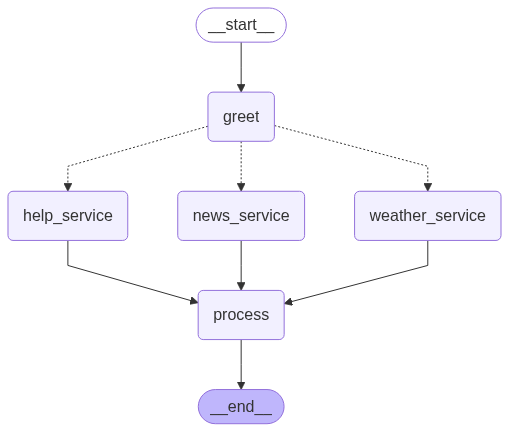

In [24]:
import operator
from typing import Annotated, Sequence, TypedDict
from langgraph.graph import StateGraph, START, END

# 상태 정의: aggregate 리스트와 라우팅을 위한 user_intent 필드 포함
class ChatState(TypedDict):
    messages: Annotated[list, operator.add]  # aggregate 대신 messages 사용
    user_intent: str  # 라우팅 조건

# 서비스 노드 정의
def greet_service(state: ChatState):
    print(f'Adding "greet" to {state["messages"]}')
    return {"messages": ["Hello!"]} 

def weather_service(state: ChatState):
    print(f'Adding "weather" to {state["messages"]}')
    return {"messages": ["The weather is sunny."]}

def news_service(state: ChatState):
    print(f'Adding "news" to {state["messages"]}')
    return {"messages": ["Here's the latest news."]}

def help_service(state: ChatState):
    print(f'Adding "help" to {state["messages"]}')
    return {"messages": ["How can I help you?"]}

def process_response(state: ChatState):
    print(f'Adding "process" to {state["messages"]}')
    return {"messages": ["Processing complete."]}

# 라우팅 함수: user_intent 값에 따라 서비스 노드 결정
def route_services(state: ChatState) -> Sequence[str]:
    if state["user_intent"] == "weather_news":
        # 날씨와 뉴스 서비스를 병렬 실행
        return ["weather_service", "news_service"]
    
    # 기본적으로 인사와 뉴스 서비스를 병렬 실행
    return ["help_service", "news_service"]

# 그래프 구성
chat_builder = StateGraph(ChatState)

# 노드 추가
chat_builder.add_node("greet", greet_service)
chat_builder.add_node("weather_service", weather_service)
chat_builder.add_node("news_service", news_service)
chat_builder.add_node("help_service", help_service)
chat_builder.add_node("process", process_response)

# 엣지 추가
chat_builder.add_edge(START, "greet")

# 중간 노드 정의
intermediates = ["weather_service", "news_service", "help_service"]

# greet 노드에서 조건부 엣지 추가
chat_builder.add_conditional_edges(
    "greet",
    route_services,
    intermediates,
)

# 중간 노드들을 process 노드에 연결
for node in intermediates:
    chat_builder.add_edge(node, "process")

chat_builder.add_edge("process", END)

# 그래프 컴파일
chat_graph = chat_builder.compile()

# 그래프 시각화
display(Image(chat_graph.get_graph().draw_mermaid_png()))

In [25]:
# "weather_news" 의도를 가지고 실행
chat_graph.invoke({"messages": [], "user_intent": "weather_news"})

Adding "greet" to []
Adding "news" to ['Hello!']
Adding "weather" to ['Hello!']
Adding "process" to ['Hello!', "Here's the latest news.", 'The weather is sunny.']


{'messages': ['Hello!',
  "Here's the latest news.",
  'The weather is sunny.',
  'Processing complete.'],
 'user_intent': 'weather_news'}

In [26]:
# 다른 의도를 가지고 실행
chat_graph.invoke({"messages": [], "user_intent": "news"})

Adding "greet" to []
Adding "help" to ['Hello!']
Adding "news" to ['Hello!']
Adding "process" to ['Hello!', 'How can I help you?', "Here's the latest news."]


{'messages': ['Hello!',
  'How can I help you?',
  "Here's the latest news.",
  'Processing complete.'],
 'user_intent': 'news'}

`(3) 다단계 분기 (Multi-step Parallel Paths)`

- **다단계 분기**는 각각의 병렬 경로에서 여러 단계의 독립적인 처리를 지원 

- 각 분기는 **서로 다른 데이터 처리 파이프라인**을 포함할 수 있어, 복잡한 워크플로우 구현이 가능

- 최종적으로 각 분기의 결과는 하나의 노드에서 **통합되어 처리**될 수 있음 

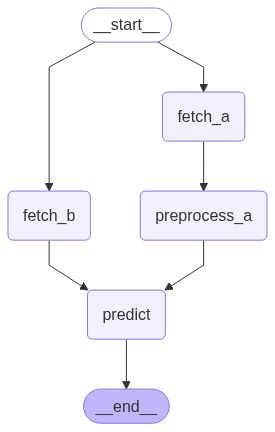

In [27]:
# 데이터 전처리와 모델 예측을 병렬로 수행하기

import operator
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END

class ModelState(TypedDict):
    data: Annotated[list, operator.add]

def fetch_data_a(state: ModelState):
    return {"data": ["Data A1"]}

def preprocess_data_a(state: ModelState):
    return {"data": ["Preprocessed A1"]}

def fetch_data_b(state: ModelState):
    return {"data": ["Data B1"]}

def make_prediction(state: ModelState):
    return {"data": ["Prediction from A and B"]}

model_builder = StateGraph(ModelState)
model_builder.add_node("fetch_a", fetch_data_a)
model_builder.add_node("preprocess_a", preprocess_data_a)
model_builder.add_node("fetch_b", fetch_data_b)
model_builder.add_node("predict", make_prediction)

model_builder.add_edge(START, "fetch_a")
model_builder.add_edge(START, "fetch_b")
model_builder.add_edge("fetch_a", "preprocess_a")
model_builder.add_edge(["preprocess_a", "fetch_b"], "predict")
model_builder.add_edge("predict", END)

model_graph = model_builder.compile()

display(Image(model_graph.get_graph().draw_mermaid_png()))

In [28]:
# 그래프 실행
model_graph.invoke({"data": []})

{'data': ['Data A1', 'Data B1', 'Preprocessed A1', 'Prediction from A and B']}

# ~ 15:10분까지 실습

`(4) 동적 엣지 생성 및 개별 상태 전달하기 (Map-Reduce 패턴)`

- **기본 동작의 한계**

    - 기본적으로 LangGraph의 노드와 엣지는 미리 정의되며, 모든 노드는 동일한 공유 상태(shared state)를 사용함. 하지만 다음과 같은 경우에는 문제가 발생할 수 있음. 

    -  **동적 엣지:** 실행 시점에 따라 연결해야 할 노드의 수가 달라지는 경우 (예: 입력 데이터에 따라 다른 개수의 하위 작업을 생성해야 하는 경우)
    -  **개별 상태:** 각 노드가 독립적인 상태를 가지고 작업해야 하는 경우 (예: 각 하위 작업이 서로 다른 데이터를 처리해야 하는 경우)

- **Map-Reduce 패턴**

    1.  **Map:**  하나의 노드(mapper)가 여러 개의 객체(또는 작업)를 생성
    2.  **Reduce:** 다른 노드(reducer)가 mapper가 생성한 객체들을 처리하고 결과를 결합

-  **`Send` 객체**

    - LangGraph에서는 `Send` 객체를 사용하여 map 단계를 구현할 수 있음 
    - `Send` 객체는 조건부 엣지(`add_conditional_edges`)의 `condition_function`에서 반환될 수 있으며, 다음과 같은 두 가지 인수를 받아서 구현

        1.  **`node_name` (str):**  실행할 노드의 이름
        2.  **`state` (dict):** 해당 노드에 전달할 개별 상태

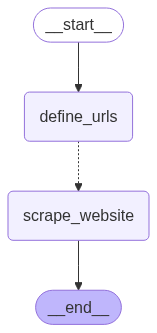

In [29]:
import operator
from typing import Annotated, List, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from IPython.display import Image, display

# 글로벌 상태 정의
class WebScrapingState(TypedDict):
    urls: List[str]  # 스크래핑할 URL 목록 (글로벌)
    scraped_data: Annotated[List[dict], operator.add]  # 스크래핑된 데이터 (글로벌, 누적)

# 로컬 상태 정의
class PrivateSate(TypedDict):
    url: str  # 스크래핑할 URL (로컬 상태)

# 노드 정의
def define_urls(state: WebScrapingState):
    """URL 목록을 정의합니다. (글로벌 상태 사용)"""
    print("Using provided URLs...")
    return {"urls": state["urls"]}  # 글로벌 상태(urls) 사용

def scrape_website(state: PrivateSate):  # 로컬 상태를 받음
    """각 웹사이트를 스크래핑합니다. (로컬 상태 사용)"""
    print(f"Scraping {state['url']}...")  # 로컬 상태(url) 사용
    # 실제 스크래핑 로직 (여기서는 시뮬레이션)
    return {"scraped_data": [f"Data from {state['url']}"]} # 글로벌 상태(scraped_data) 사용

def route_to_scraping(state: WebScrapingState):
    """스크래핑 노드로 라우팅합니다. (글로벌 상태 사용, 로컬 상태 생성)"""
    # 글로벌 상태(urls)를 사용하여 로컬 상태({"url": url})를 생성하고 Send로 전달
    return [Send("scrape_website", {"url": url}) for url in state["urls"]]


# 그래프 구성
graph = StateGraph(WebScrapingState)  
graph.add_node("define_urls", define_urls)
graph.add_node("scrape_website", scrape_website)

graph.set_entry_point("define_urls")

graph.add_conditional_edges(
    "define_urls",
    route_to_scraping,
    ["scrape_website"],  # 스크래핑 노드로 라우팅
)

graph.add_edge("scrape_website", END)

# 그래프 컴파일
compiled_graph = graph.compile()

# 그래프 시각화
display(Image(compiled_graph.get_graph().draw_mermaid_png()))  

In [30]:
# 그래프 실행 (외부에서 URL 목록 입력)
initial_state = {"urls": ["https://example.com", "https://example.net", "https://example.org"]}
result = compiled_graph.invoke(initial_state)

Using provided URLs...
Scraping https://example.com...
Scraping https://example.net...
Scraping https://example.org...


```mermaid
graph LR
    define_urls[define_urls]
    scrape_website[scrape_website]
    _start((START)) --> define_urls
    define_urls --"Send(scrape_website)"--> scrape_website
    scrape_website --> _end((END))

```

In [31]:
pprint(result)

{'scraped_data': ['Data from https://example.com',
                  'Data from https://example.net',
                  'Data from https://example.org'],
 'urls': ['https://example.com', 'https://example.net', 'https://example.org']}


### **`Send` 객체의 사용 예시**

- 문서 요약 시스템 (대용량 텍스트 처리)
- 긴 문서를 여러 부분으로 나누어 병렬로 요약한 후 통합하는 시스템

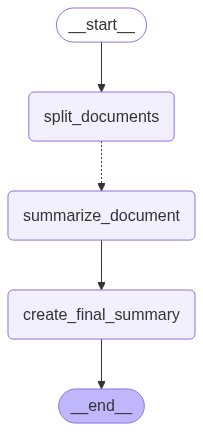

In [32]:
import operator
from typing import Annotated, List, Dict, Tuple, Any
from typing_extensions import TypedDict
from langchain_core.documents import Document
from langgraph.types import Send
from langgraph.graph import END, START, StateGraph
from langchain_openai import ChatOpenAI  
from IPython.display import Image, display

# LLM 모델 초기화
model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

class SummarizationState(TypedDict):
    contents: List[Document]  # 초기 Document 객체 리스트
    chunks: List[Dict[str, Any]]  # 청크 리스트 (인덱스, 내용, 메타데이터 포함)
    summaries: Annotated[List[Tuple[int, str]], operator.add]  # (인덱스, 요약) 튜플 리스트
    final_summary: str

class DocumentState(TypedDict):
    content: str
    index: int  # 청크의 순서를 나타내는 인덱스

def split_documents(state: SummarizationState):
    """각 Document를 순서를 유지하며 청크로 분할"""
    chunks = []
    chunk_size = 1000
    global_chunk_index = 0
    
    # 각 Document를 순차적으로 처리
    for doc_index, document in enumerate(state["contents"]):
        content = document.page_content
        
        # 해당 문서를 청크로 분할
        for i in range(0, len(content), chunk_size):
            chunk_content = content[i:i + chunk_size]
            
            # 빈 청크는 스킵
            if chunk_content.strip():
                chunks.append({
                    "index": global_chunk_index,
                    "content": chunk_content,
                    "source_document": doc_index,
                    "source_metadata": document.metadata
                })
                global_chunk_index += 1
    
    return {"chunks": chunks}

def summarize_document(state: DocumentState):
    """개별 문서 청크를 요약"""
    prompt = f"""다음 텍스트를 2-3문장으로 간결하게 요약해주세요:
    
    {state['content']}
    """
    
    try:
        response = model.invoke(prompt)
        summary = response.content
    except Exception as e:
        summary = f"요약 생성 중 오류 발생: {str(e)}"
    
    # 순서 정보와 함께 요약 반환
    return {"summaries": [(state["index"], summary)]}

def continue_to_summarization(state: SummarizationState):
    """각 청크를 병렬로 요약하도록 Send 작업 생성"""
    return [
        Send("summarize_document", {
            "content": chunk["content"],
            "index": chunk["index"]
        }) 
        for chunk in state["chunks"]
    ]

def create_final_summary(state: SummarizationState):
    """순서를 유지하며 최종 요약 생성"""
    # 인덱스별로 요약을 정렬
    sorted_summaries = sorted(state["summaries"], key=lambda x: x[0])
    
    # 순서대로 요약들을 결합
    ordered_summaries = [summary for _, summary in sorted_summaries]
    combined_summaries = "\n\n".join(ordered_summaries)
    
    prompt = f"""다음은 문서를 청크별로 요약한 내용들입니다. 
    이들을 종합하여 하나의 포괄적이고 일관성 있는 최종 요약을 작성해주세요.
    원본 문서의 순서와 흐름을 유지하면서 핵심 내용을 간결하게 정리해주세요:
    
    {combined_summaries}
    
    최종 요약:
    """
    
    try:
        response = model.invoke(prompt)
        final_summary = response.content
    except Exception as e:
        final_summary = f"최종 요약 생성 중 오류 발생: {str(e)}"
    
    return {"final_summary": final_summary}

# 그래프 구성
builder = StateGraph(SummarizationState)
builder.add_node("split_documents", split_documents)
builder.add_node("summarize_document", summarize_document)
builder.add_node("create_final_summary", create_final_summary)

# 엣지 연결
builder.add_edge(START, "split_documents")
builder.add_conditional_edges("split_documents", continue_to_summarization, ["summarize_document"])
builder.add_edge("summarize_document", "create_final_summary")
builder.add_edge("create_final_summary", END)

# 그래프 컴파일
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("data/labor_law.pdf")
documents = loader.load()

print(f"로드된 페이지 수: {len(documents)}")

로드된 페이지 수: 20


In [35]:
# PDF 문서 요약 실행
initial_state = {
    "contents": documents,
}
    
for step in graph.stream(initial_state, stream_mode="values"):
    if "chunks" in step:
        print(f"처리 중인 청크 수: {len(step['chunks'])}")
    if "summaries" in step:
        print(f"현재까지 생성된 요약 수: {len(step['summaries'])}")
    if "final_summary" in step:
        print("최종 요약 생성 중...")
        print(step["final_summary"])  # 최종 요약 출력
    print("-"*100)

현재까지 생성된 요약 수: 0
----------------------------------------------------------------------------------------------------
처리 중인 청크 수: 48
현재까지 생성된 요약 수: 0
----------------------------------------------------------------------------------------------------
처리 중인 청크 수: 48
현재까지 생성된 요약 수: 48
----------------------------------------------------------------------------------------------------
처리 중인 청크 수: 48
현재까지 생성된 요약 수: 48
최종 요약 생성 중...
근로기준법은 근로자의 기본적 생활 보장과 국민경제의 균형 발전을 목적으로 하며, 근로자와 사용자의 권리와 의무, 근로계약, 임금, 근로시간, 휴가, 해고, 재해보상, 직장 내 괴롭힘 예방 등 근로조건의 최저기준을 규정한다. 이 법은 상시 5인 이상 사업장에 적용되며, 근로조건은 근로자와 사용자가 동등한 지위에서 자유롭게 결정하되 법정 기준에 미치지 못하는 조건은 무효로 한다.

사용자는 성별, 국적, 신앙 등에 따른 차별과 강제노동을 금지하며, 근로계약 체결 시 임금, 근로시간, 휴일, 연차 유급휴가 등 주요 조건을 서면 또는 전자문서로 명확히 해야 한다. 임금은 매월 1회 이상 정해진 날짜에 통화로 전액 직접 지급해야 하며, 임금 체불 시에는 노동위원회가 명단 공개 및 이행강제금을 부과할 수 있다. 도급 사업에서는 하수급인과 원수급인, 직상 수급인이 연대하여 임금 지급 책임을 진다.

근로시간은 1일 8시간, 주 40시간을 원칙으로 하며, 탄력적 근로시간제와 선택적 근로시간제를 도입해 일정 범위 내에서 조정할 수 있다. 연장근로, 휴일근로, 야간근로에 대해서는 통상임금의 일정 비율 이상을 가산하여 지

In [36]:
# 최종 상태 출려
print("최종 상태:")
print("최종 요약:", step.get("final_summary", "요약이 생성되지 않았습니다."))
print("전체 청크 수:", len(step.get("chunks", [])))
print("전체 요약 수:", len(step.get("summaries", [])))
print("전체 문서 수:", len(step.get("contents", [])))

최종 상태:
최종 요약: 근로기준법은 근로자의 기본적 생활 보장과 국민경제의 균형 발전을 목적으로 하며, 근로자와 사용자의 권리와 의무, 근로계약, 임금, 근로시간, 휴가, 해고, 재해보상, 직장 내 괴롭힘 예방 등 근로조건의 최저기준을 규정한다. 이 법은 상시 5인 이상 사업장에 적용되며, 근로조건은 근로자와 사용자가 동등한 지위에서 자유롭게 결정하되 법정 기준에 미치지 못하는 조건은 무효로 한다.

사용자는 성별, 국적, 신앙 등에 따른 차별과 강제노동을 금지하며, 근로계약 체결 시 임금, 근로시간, 휴일, 연차 유급휴가 등 주요 조건을 서면 또는 전자문서로 명확히 해야 한다. 임금은 매월 1회 이상 정해진 날짜에 통화로 전액 직접 지급해야 하며, 임금 체불 시에는 노동위원회가 명단 공개 및 이행강제금을 부과할 수 있다. 도급 사업에서는 하수급인과 원수급인, 직상 수급인이 연대하여 임금 지급 책임을 진다.

근로시간은 1일 8시간, 주 40시간을 원칙으로 하며, 탄력적 근로시간제와 선택적 근로시간제를 도입해 일정 범위 내에서 조정할 수 있다. 연장근로, 휴일근로, 야간근로에 대해서는 통상임금의 일정 비율 이상을 가산하여 지급해야 하며, 근로자대표와 서면 합의 시 임금 대신 보상 휴가를 제공할 수 있다. 근로일 종료 후 최소 11시간 휴식시간을 보장하고, 휴게시간과 주당 평균 1회 이상의 유급휴일을 부여해야 한다.

연차 유급휴가는 1년간 80% 이상 출근한 근로자에게 15일을 부여하며, 3년 이상 근속 시 최대 25일까지 추가 휴가를 허용한다. 사용자는 근로자가 청구한 시기에 휴가를 주어야 하며, 사업 운영에 중대한 지장이 있을 경우에만 시기 변경이 가능하다. 미사용 휴가는 1년 내 소멸되나, 사용자의 귀책사유가 있을 경우 예외가 인정된다.

15세 미만(중학교 재학 중인 18세 미만 포함)은 원칙적으로 근로자로 사용할 수 없으며, 18세 미만과 임산부는 보건상 유해하거나 위험한 사업에 종사할 수 없고, 야간 및 휴일 근로가 제한된다. 18세 미만 근로자의

# ~ 15:30분까지